<a href="https://colab.research.google.com/github/ecarreram-blip/se-alesysistemas/blob/main/pregunta_1_del_2_parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

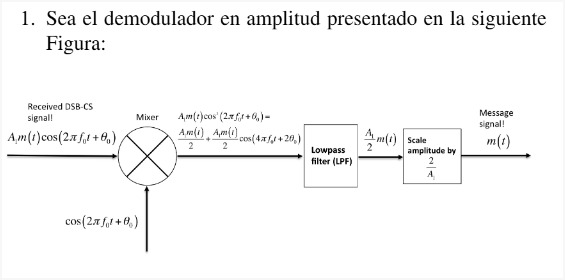

#Carga y preparación de la señal de audio



En esta sección se carga el archivo de audio desde Google Drive.
Se convierte la señal a formato flotante y luego a mono para procesar una única pista.
Finalmente, se muestra información básica de la señal.

#link del audio en google DRIVE

https://drive.google.com/file/d/1O0uNCJ__eXcp5of8CV-StRZ4SUiVkYC_/view?usp=drive_link

In [55]:
# ==========================================================
# CARGA DE AUDIO DESDE GOOGLE DRIVE
# ==========================================================
from google.colab import drive
import scipy.io.wavfile as wav
import numpy as np
import matplotlib.pyplot as plt

# Montar Google Drive
drive.mount('/content/drive')

# Ruta del archivo en Drive (ajústala según tu carpeta)
audio_path = "/content/drive/MyDrive/Colab Notebooks/audio.wav"

# Cargar el audio
fs, data = wav.read(audio_path)
print("Frecuencia de muestreo:", fs, "Hz")
print("Shape original:", data.shape)

# Convertir a flotante y normalizar
if data.dtype == np.int16:
    data = data.astype(np.float32) / 32768.0
elif data.dtype == np.int32:
    data = data.astype(np.float32) / 2147483648.0
elif data.dtype == np.uint8:
    data = (data.astype(np.float32) - 128) / 128.0
else:
    data = data.astype(np.float32)

# Convertir a mono si es estéreo
if data.ndim == 2:
    m_t = data.mean(axis=1)
else:
    m_t = data.copy()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Frecuencia de muestreo: 16000 Hz
Shape original: (90858,)


#Visualización de la señal en el tiempo

Explicación:

Se observa cómo cambia la amplitud de la señal respecto al tiempo.
Esto permite reconocer si la señal es modulada AM.

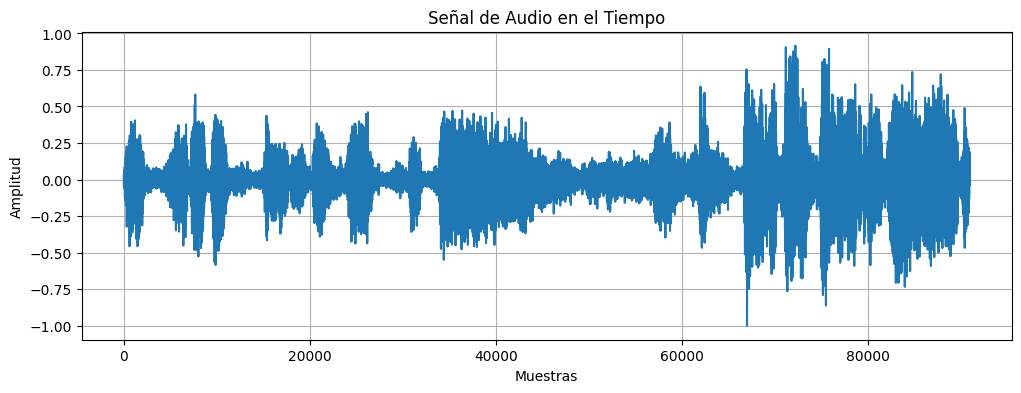

In [56]:
plt.figure(figsize=(12,4))
plt.plot(m_t)
plt.title("Señal de Audio en el Tiempo")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()


#Reproducción del audio original

Explicación:

Se reproduce la señal original para analizar el mensaje auditivamente.

In [57]:
from IPython.display import Audio
Audio(m_t, rate=fs)


#Demodulación mediante filtro pasa bajos

Explicación:

Para recuperar el mensaje original de una señal AM se aplica un filtro pasa bajos.
Se toma una frecuencia de corte de 4 kHz, adecuada para voz.

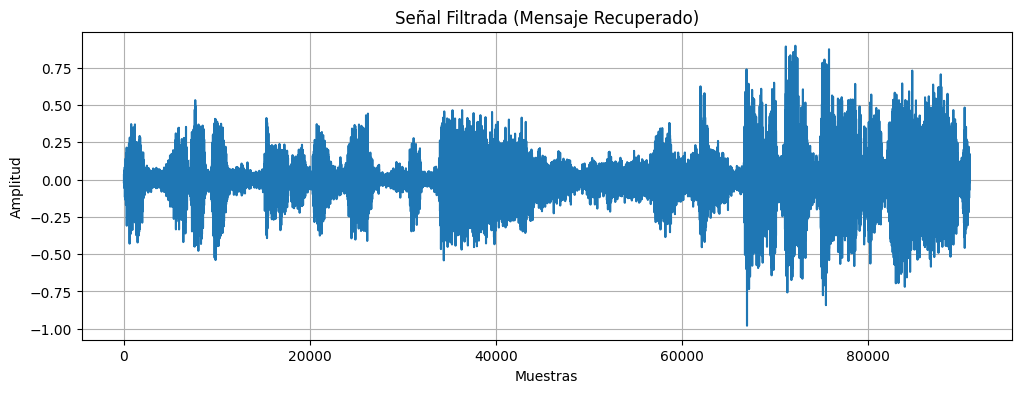

In [58]:
# ==========================================================
# FILTRADO PASA BAJOS PARA EXTRAER EL MENSAJE
# ==========================================================
from scipy.signal import butter, filtfilt

fc = 4000  # 4 kHz
wn = fc / (fs / 2)
b, a = butter(5, wn, 'low')
m_filtrado = filtfilt(b, a, m_t)

plt.figure(figsize=(12,4))
plt.plot(m_filtrado)
plt.title("Señal Filtrada (Mensaje Recuperado)")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()



#Espectro en frecuencia antes y después de la demodulación

Explicación:

Se calcula la FFT para observar cómo el espectro pasa de contener portadora y bandas laterales
a la banda base del mensaje ya recuperado.

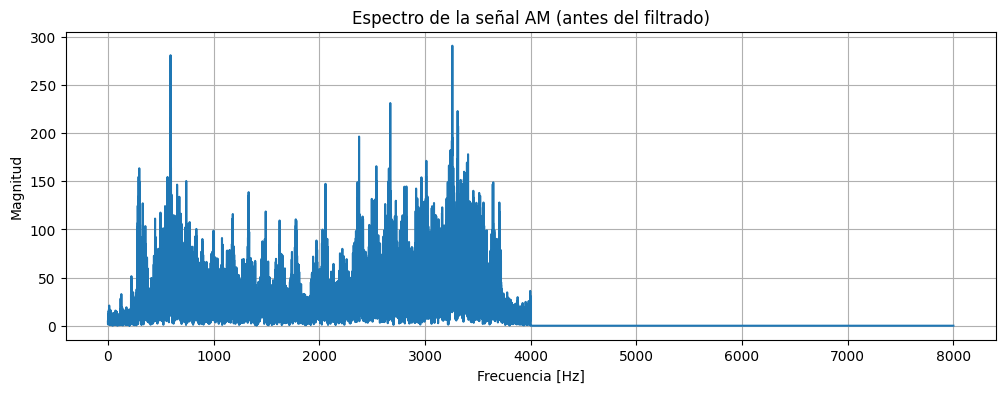

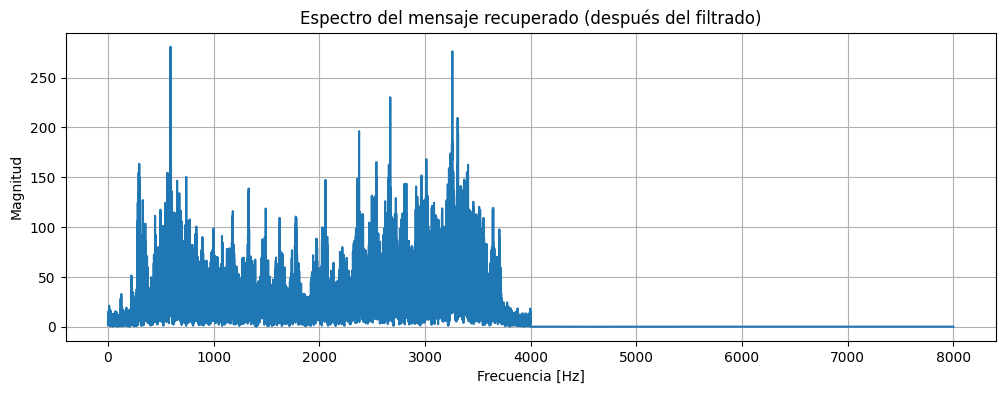

In [59]:
# ==========================================================
# FFT PARA VER ESPECTROS
# ==========================================================
def plot_fft(signal, fs, title):
    N = len(signal)
    f = np.linspace(0, fs/2, N//2)
    X = np.fft.fft(signal)
    X_mag = np.abs(X[:N//2])

    plt.figure(figsize=(12,4))
    plt.plot(f, X_mag)
    plt.title(title)
    plt.xlabel("Frecuencia [Hz]")
    plt.ylabel("Magnitud")
    plt.grid(True)
    plt.show()

plot_fft(m_t, fs, "Espectro de la señal AM (antes del filtrado)")
plot_fft(m_filtrado, fs, "Espectro del mensaje recuperado (después del filtrado)")


#Reproducción del mensaje demodulado

Explicación:

Se escucha el mensaje recuperado luego del filtrado pasa bajos,
comprobando que la señal ha sido demodulada correctamente.

In [60]:
Audio(m_filtrado, rate=fs)


Instalar y configurar Streamlit

In [61]:
%%writefile app.py
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt
from scipy.io import wavfile

st.title("📡 Dashboard de Demodulación AM")

audio_file = st.file_uploader("Sube tu archivo .wav", type=["wav"])

if audio_file is not None:
    fs, data = wavfile.read(audio_file)

    if data.ndim == 2:
        m_t = data.mean(axis=1)
    else:
        m_t = data.astype(np.float32)

    st.audio(audio_file)

    st.subheader("🔹 Señal original")
    fig, ax = plt.subplots()
    ax.plot(m_t)
    ax.grid()
    st.pyplot(fig)

    fc = st.slider("📌 Frecuencia de corte (Hz)", 500, 10000, 4000)
    wn = fc / (fs/2)
    b, a = butter(5, wn, 'low')
    m_filtrado = filtfilt(b, a, m_t)

    st.subheader("🔹 Señal filtrada")
    fig, ax = plt.subplots()
    ax.plot(m_filtrado, color='green')
    ax.grid()
    st.pyplot(fig)

    def plot_fft(signal):
        N = len(signal)
        f = np.linspace(0, fs/2, N//2)
        X = np.fft.fft(signal)
        X_mag = np.abs(X[:N//2])
        fig, ax = plt.subplots()
        ax.plot(f, X_mag)
        ax.grid()
        return fig

    st.subheader("📈 FFT original")
    st.pyplot(plot_fft(m_t))

    st.subheader("📈 FFT filtrada")
    st.pyplot(plot_fft(m_filtrado))

    st.subheader("🎧 Audio demodulado")
    st.audio(m_filtrado, sample_rate=fs)

else:
    st.info("Sube el archivo de audio para continuar.")

Overwriting app.py


In [53]:
!pip install streamlit
!wget https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64 -O cloudflared
!chmod +x cloudflared

--2025-12-04 03:58:41--  https://github.com/cloudflare/cloudflared/releases/latest/download/cloudflared-linux-amd64
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64 [following]
--2025-12-04 03:58:41--  https://github.com/cloudflare/cloudflared/releases/download/2025.11.1/cloudflared-linux-amd64
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://release-assets.githubusercontent.com/github-production-release-asset/106867604/955e9d1b-ac5e-4188-8867-e5f53958a8fe?sp=r&sv=2018-11-09&sr=b&spr=https&se=2025-12-04T04%3A52%3A20Z&rscd=attachment%3B+filename%3Dcloudflared-linux-amd64&rsct=application%2Foctet-stream&skoid=96c2d410-5711-43a1-aedd-ab1947aa7ab0&sktid=398a6654-997b-47e9-b12b-9515b896b4de&skt=2025-12-04

In [54]:
!streamlit run app.py &>/content/log.txt &

In [62]:
!./cloudflared tunnel --url http://localhost:8501 --loglevel debug

2025-12-04T03:58:49Z INF Thank you for trying Cloudflare Tunnel. Doing so, without a Cloudflare account, is a quick way to experiment and try it out. However, be aware that these account-less Tunnels have no uptime guarantee, are subject to the Cloudflare Online Services Terms of Use (https://www.cloudflare.com/website-terms/), and Cloudflare reserves the right to investigate your use of Tunnels for violations of such terms. If you intend to use Tunnels in production you should use a pre-created named tunnel by following: https://developers.cloudflare.com/cloudflare-one/connections/connect-apps
2025-12-04T03:58:49Z INF Requesting new quick Tunnel on trycloudflare.com...
2025-12-04T03:58:54Z INF +--------------------------------------------------------------------------------------------+
2025-12-04T03:58:54Z INF |  Your quick Tunnel has been created! Visit it at (it may take some time to be reachable):  |
2025-12-04T03:58:54Z INF |  https://individual-jazz-detroit-dancing.trycloudflare